1. Construcción de 6 modelos diferentes

Dado que estamos trabajando con un TabTransformer VAE, podemos explorar diversas arquitecturas y metodologías para la generación de datos sintéticos:

*TabTransformer VAE (actual) – Modelo base con arquitectura VAE y Transformer.

*GAN (Generative Adversarial Network) – Modelo basado en redes adversarias generativas para comparación.

*VAE tradicional – Un autoencoder variacional sin Transformer para evaluar su desempeño.

*Normalizing Flows – Un modelo generativo basado en transformaciones invertibles.

*Diffusion Models – Un enfoque basado en modelos de difusión como alternativa moderna.

*Random Forest con Bootstrap – Si bien no es generativo, puede ayudar a evaluar la distribución de los datos sintéticos.


2. Comparación de rendimiento y selección de los mejores modelos

En entregas anteriores se hicieron pruebas de algunos modelos como el GAN y de acuerdo a la literatura se fueron descartando, sobre todo por el manejo de los datos categóricos. Aqui algunos motivos:

*GAN: Las GANs suelen funcionar bien en imágenes pero tienen problemas con datos tabulares, especialmente con características categóricas. Además, son notoriamente difíciles de entrenar y propensas al modo colapso (generar datos repetitivos en lugar de diversificados)

*VAE tradicional: No captura dependencias no lineales complejas tan bien como un Transformer. En datos tabulares, puede generar valores no realistas para variables categóricas debido a la parametrización gaussiana

*Normalizing Flows:Estos modelos requieren transformaciones invertibles, lo que no es ideal para datos mixtos (numéricos y categóricos). Además, pueden ser computacionalmente costosos y difíciles de escalar

*Diffusion Models: Aunque los modelos de difusión han tenido éxito en generación de imágenes, su aplicación en datos tabulares aún es experimental. Además, el proceso de generación es lento comparado con alternativas más eficientes

*Random Forest con Bootstrap:No es un modelo generativo real, sino una técnica de remuestreo. No puede generar nuevas combinaciones de datos más allá de lo observado en el conjunto de entrenamiento.

Después de descartar los otros modelos, TabTransformer VAE sigue siendo una opción fuerte por varias razones:
*Maneja bien datos mixtos (numéricos + categóricos)

*Captura relaciones complejas

*Generaliza mejor y evita overfitting

*Generación eficiente de datos sintéticos


4. Ajuste de hiperparámetros

Hiperparámetros del modelo
Estos afectan la arquitectura y el aprendizaje del TabTransformer VAE:

a) Estructura del Transformer

embed_dim = 8 → Dimensión de los embeddings para variables categóricas y numéricas.
num_heads = 2 → Número de cabezas de atención en cada bloque Transformer.
num_layers = 2 → Cantidad de bloques Transformer en la arquitectura.
dropout = 0.1 → Probabilidad de dropout para regularización.

b)Espacio Latente (VAE)

latent_dim = 16 → Dimensión del espacio latente donde se representa la distribución de los datos.

c)Decodificador

hidden_dim = 128 → Tamaño de la capa oculta en la red neuronal del decodificador.

Hiperparámetros de entrenamiento
Estos afectan la forma en que el modelo aprende:
a)Optimización

lr = 1e-2 → Tasa de aprendizaje del optimizador Adam.
b)Pérdidas

mse_loss_fn → MSELoss para la reconstrucción de variables numéricas.
F.cross_entropy → Pérdida para las variables categóricas.
kl_loss → Regularización KL para el VAE

c)Datos y entrenamiento

batch_size = 64 → Tamaño del batch en cada iteración del entrenamiento.
num_epochs = 4000 → Número total de épocas de entrenamiento.
global_step % 100_000 == 0 → Cada 100,000 pasos, se generan datos sintéticos de prueba.


In [1]:
import os
import csv
import datetime
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# ===============================
# 1. Definición del Modelo VAE con Transformer
# ===============================

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x

class TabTransformerVAE(nn.Module):
    def __init__(self, num_numerical, cat_cardinalities, embed_dim, num_heads, num_layers, latent_dim, dropout=0.1):
        """
        Parámetros:
          - num_numerical: número de features numéricas.
          - cat_cardinalities: lista con la cantidad de categorías de cada feature categórica.
          - embed_dim: dimensión de los embeddings.
          - num_heads: número de cabezas de atención.
          - num_layers: cantidad de bloques transformer.
          - latent_dim: dimensión del espacio latente.
          - dropout: tasa de dropout.
        """
        super().__init__()
        self.num_numerical = num_numerical
        self.cat_cardinalities = cat_cardinalities
        self.num_categorical = len(cat_cardinalities)

        # Embeddings para variables categóricas
        self.cat_embeds = nn.ModuleList([nn.Embedding(card, embed_dim) for card in cat_cardinalities])
        # Proyección para variables numéricas
        self.num_projection = nn.Linear(num_numerical, embed_dim)
        # Token CLS
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Bloques transformer
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)
        ])

        # Obtención del vector latente a partir del token CLS
        self.fc_mu = nn.Linear(embed_dim, latent_dim)
        self.fc_logvar = nn.Linear(embed_dim, latent_dim)

        # Decodificador: salida = [num_numerical] + [sum(cat_cardinalities)]
        total_cat_dims = sum(cat_cardinalities)
        decoder_output_dim = num_numerical + total_cat_dims
        hidden_dim = 128
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, decoder_output_dim)
        )

    def encode(self, numerical_data, categorical_data):
        batch_size = numerical_data.size(0)
        num_feat = self.num_projection(numerical_data).unsqueeze(1)
        cat_feats = [embed(categorical_data[:, i]).unsqueeze(1)
                     for i, embed in enumerate(self.cat_embeds)]
        x = torch.cat([num_feat] + cat_feats, dim=1)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x.transpose(0, 1)
        for layer in self.transformer_layers:
            x = layer(x)
        x = x.transpose(0, 1)
        cls_output = x[:, 0, :]
        mu = self.fc_mu(cls_output)
        logvar = self.fc_logvar(cls_output)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        recon = self.decoder(z)
        num_recon = recon[:, :self.num_numerical]
        cat_recon = []
        start = self.num_numerical
        for card in self.cat_cardinalities:
            end = start + card
            cat_recon.append(recon[:, start:end])
            start = end
        return num_recon, cat_recon

    def forward(self, numerical_data, categorical_data):
        mu, logvar = self.encode(numerical_data, categorical_data)
        z = self.reparameterize(mu, logvar)
        num_recon, cat_recon = self.decode(z)
        return num_recon, cat_recon, mu, logvar

# ===============================
# 2. Preparación de los Datos
# ===============================

# Cargamos el CSV
df = pd.read_csv("final.csv")
df = df.drop(columns=["indice"])
# Convertimos algunas columnas a string para categorizarlas
df['estacionamientos'] = df['estacionamientos'].astype(int).astype(str)
df['edad'] = df['edad'].astype(int).astype(str)

# Definir columnas según lo que queremos modelar
numerical_cols = ['area_construida', 'latitud', 'longitud', 'precio_oferta', 'precio_m2']
categorical_cols = ['tipo_propiedad', 'Municipio', 'Colonia', 'cp', 'estacionamientos', 'edad', 'recamaras', 'banos']

# Escalado: creamos un scaler para cada columna numérica
scalers = {}
for col in numerical_cols:
    scaler = StandardScaler()
    df[[col]] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler

# Mostrar cardinalidades de las categóricas
cat_cardinalities = {col: df[col].nunique() for col in categorical_cols}
print("Cardinalidades de variables categóricas:", cat_cardinalities)

# Crear mapeos para las variables categóricas
cat_mapping = {}
reverse_cat_mapping = {}
for col in categorical_cols:
    categories = df[col].astype('category').cat.categories
    mapping = {cat: code for code, cat in enumerate(categories)}
    reverse_mapping = {code: cat for code, cat in enumerate(categories)}
    cat_mapping[col] = mapping
    reverse_cat_mapping[col] = reverse_mapping

class TabularDataset(Dataset):
    def __init__(self, df, numerical_cols, categorical_cols, cat_mapping):
        self.numerical_data = df[numerical_cols].to_numpy(dtype=np.float32)
        self.categorical_data = np.stack([
            df[col].map(cat_mapping[col]).to_numpy(dtype=np.int64)
            for col in categorical_cols
        ], axis=1)

    def __len__(self):
        return len(self.numerical_data)

    def __getitem__(self, idx):
        num = torch.tensor(self.numerical_data[idx])
        cat = torch.tensor(self.categorical_data[idx])
        return num, cat

dataset = TabularDataset(df, numerical_cols, categorical_cols, cat_mapping)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ===============================
# 3. Entrenamiento y Checkpoints / Logging
# ===============================

embed_dim = 8
num_heads = 2
num_layers = 2
latent_dim = 16
cat_card_list = [cat_cardinalities[col] for col in categorical_cols]

model = TabTransformerVAE(num_numerical=len(numerical_cols),
                          cat_cardinalities=cat_card_list,
                          embed_dim=embed_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

# Parámetros para checkpoints y log
checkpoint_path = "checkpoint.pt"
log_csv_path = "training_log.csv"

# Si existe un checkpoint, cargar estado
start_epoch = 0
global_step = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    global_step = checkpoint["global_step"]
    print(f"Cargando checkpoint del epoch {start_epoch}")

# Si no existe el CSV de log, crearlo con header
if not os.path.exists(log_csv_path):
    with open(log_csv_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "epoch", "loss_total", "loss_num", "loss_cat", "loss_kl"])

num_epochs = 4000

for epoch in range(start_epoch, num_epochs):
    epoch_loss_total = 0.0
    epoch_loss_num = 0.0
    epoch_loss_cat = 0.0
    epoch_loss_kl = 0.0
    num_batches = 0

    for numerical_batch, categorical_batch in dataloader:
        optimizer.zero_grad()
        num_recon, cat_recon, mu, logvar = model(numerical_batch, categorical_batch)

        loss_num = mse_loss_fn(num_recon, numerical_batch)
        loss_cat = 0.0
        for i in range(len(categorical_cols)):
            loss_cat += F.cross_entropy(cat_recon[i], categorical_batch[:, i])
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        loss = loss_num + loss_cat + kl_loss
        loss.backward()
        optimizer.step()

        epoch_loss_total += loss.item()
        epoch_loss_num += loss_num.item()
        epoch_loss_cat += loss_cat.item()
        epoch_loss_kl += kl_loss.item()
        num_batches += 1
        global_step += 1

        if global_step % 100_000 == 0:
            model.eval()
            with torch.no_grad():
                synthetic_batch_size = 5
                z = torch.randn(synthetic_batch_size, latent_dim)
                num_syn, cat_syn_logits = model.decode(z)
                num_syn_np = num_syn.cpu().numpy()

                synthetic_nums = []
                for i, col in enumerate(numerical_cols):
                    col_vals = num_syn_np[:, i].reshape(-1, 1)
                    col_inv = scalers[col].inverse_transform(col_vals).flatten()
                    synthetic_nums.append(col_inv)
                synthetic_nums = np.column_stack(synthetic_nums)

                synthetic_cat = []
                for i, logits in enumerate(cat_syn_logits):
                    preds = torch.argmax(logits, dim=1).cpu().numpy()
                    preds = [reverse_cat_mapping[categorical_cols[i]][p] for p in preds]
                    synthetic_cat.append(preds)
                synthetic_cat = np.column_stack(synthetic_cat)

                synthetic_df = pd.DataFrame(synthetic_nums, columns=numerical_cols)
                for i, col in enumerate(categorical_cols):
                    synthetic_df[col] = synthetic_cat[:, i]

                print(f"\n[Step {global_step}] Ejemplo de datos sintéticos:")
                print(synthetic_df.head())
            model.train()

    avg_loss_total = epoch_loss_total / num_batches
    avg_loss_num = epoch_loss_num / num_batches
    avg_loss_cat = epoch_loss_cat / num_batches
    avg_loss_kl = epoch_loss_kl / num_batches

    print(f"Epoch {epoch+1}/{num_epochs} - Loss Total: {avg_loss_total:.4f} | Num Loss: {avg_loss_num:.4f} | Cat Loss: {avg_loss_cat:.4f} | KL Loss: {avg_loss_kl:.4f}")

    # Guardar log en CSV (agregar una fila)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(log_csv_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([timestamp, epoch+1, avg_loss_total, avg_loss_num, avg_loss_cat, avg_loss_kl])

    # Guardar checkpoint cada época (o cada N epochs)
    checkpoint = {
        "epoch": epoch,
        "global_step": global_step,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)


Cardinalidades de variables categóricas: {'tipo_propiedad': 2, 'Municipio': 16, 'Colonia': 1222, 'cp': 950, 'estacionamientos': 11, 'edad': 91, 'recamaras': 11, 'banos': 11}


/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_87252/3490699043.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Cargando checkpoint del epoch 1022
Epoch 1023/4000 - Loss Total: 2.3559 | Num Loss: 0.2965 | Cat Loss: 0.8442 | KL Loss: 1.2151
Epoch 1024/4000 - Loss Total: 2.3570 | Num Loss: 0.2949 | Cat Loss: 0.8453 | KL Loss: 1.2168
Epoch 1025/4000 - Loss Total: 2.3564 | Num Loss: 0.2958 | Cat Loss: 0.8423 | KL Loss: 1.2183
Epoch 1026/4000 - Loss Total: 2.3489 | Num Loss: 0.2960 | Cat Loss: 0.8361 | KL Loss: 1.2169
Epoch 1027/4000 - Loss Total: 2.3538 | Num Loss: 0.2952 | Cat Loss: 0.8429 | KL Loss: 1.2157
Epoch 1028/4000 - Loss Total: 2.3558 | Num Loss: 0.2952 | Cat Loss: 0.8435 | KL Loss: 1.2172
Epoch 1029/4000 - Loss Total: 2.3540 | Num Loss: 0.2954 | Cat Loss: 0.8417 | KL Loss: 1.2169
Epoch 1030/4000 - Loss Total: 2.3571 | Num Loss: 0.2952 | Cat Loss: 0.8448 | KL Loss: 1.2172
Epoch 1031/4000 - Loss Total: 2.3650 | Num Loss: 0.2950 | Cat Loss: 0.8522 | KL Loss: 1.2178
Epoch 1032/4000 - Loss Total: 2.3533 | Num Loss: 0.2949 | Cat Loss: 0.8409 | KL Loss: 1.2176
Epoch 1033/4000 - Loss Total: 2.354

´´´
Cardinalidades de variables categóricas: {'tipo_propiedad': 2, 'Municipio': 16, 'Colonia': 1222, 'cp': 950, 'estacionamientos': 11, 'edad': 91, 'recamaras': 11, 'banos': 11}
´´´

In [7]:
ls

TABTRASNFORMER.ipynb  final.csv
checkpoint.pt         training_log.csv


In [8]:
df_logs = pd.read_csv("training_log.csv")
df_logs

,timestamp,epoch,loss_total,loss_num,loss_cat,loss_kl
0,2025-02-12 20:07:41,1,13.752757,0.528518,12.353585,0.870654
1,2025-02-12 20:07:57,2,9.026920,0.368844,7.435230,1.222845
2,2025-02-12 20:08:15,3,7.614089,0.342485,6.040275,1.231329
3,2025-02-12 20:08:31,4,6.883336,0.328362,5.354229,1.200744
4,2025-02-12 20:08:47,5,6.391731,0.319630,4.899327,1.172774
...,...,...,...,...,...,...
3995,2025-02-15 21:26:47,3996,2.226216,0.296925,0.715683,1.213607
3996,2025-02-15 21:27:00,3997,2.222917,0.295338,0.713767,1.213812
3997,2025-02-15 21:27:14,3998,2.216800,0.296027,0.706090,1.214684
3998,2025-02-15 21:27:28,3999,2.223825,0.298238,0.712806,1.212781


In [9]:
synthetic_batch_size = 1000
z = torch.randn(synthetic_batch_size, latent_dim)
num_syn, cat_syn_logits = model.decode(z)
num_syn_np = num_syn.detach().numpy()

synthetic_nums = []
for i, col in enumerate(numerical_cols):
    col_vals = num_syn_np[:, i].reshape(-1, 1)
    col_inv = scalers[col].inverse_transform(col_vals).flatten()
    synthetic_nums.append(col_inv)
synthetic_nums = np.column_stack(synthetic_nums)

synthetic_cat = []
for i, logits in enumerate(cat_syn_logits):
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    preds = [reverse_cat_mapping[categorical_cols[i]][p] for p in preds]
    synthetic_cat.append(preds)
synthetic_cat = np.column_stack(synthetic_cat)

synthetic_df = pd.DataFrame(synthetic_nums, columns=numerical_cols)
for i, col in enumerate(categorical_cols):
    synthetic_df[col] = synthetic_cat[:, i]

In [12]:
synthetic_df.sample(10)

,area_construida,latitud,longitud,precio_oferta,precio_m2,tipo_propiedad,Municipio,Colonia,cp,estacionamientos,edad,recamaras,banos
89,122.932220,19.402515,-99.118858,31938.810547,233.268021,Departamento,Cuauhtémoc,Tabacalera,13010,2,5,3,1
460,140.375351,19.418264,-99.171364,49725.554688,400.253784,Departamento,Cuauhtémoc,Condesa,6140,3,9,2,2
332,250.379456,19.278044,-99.199303,47966.164062,174.779678,Departamento,Coyoacán,Jardines Del Pedregal San Angel,4500,2,17,3,2
711,115.771980,19.406483,-99.238022,15408.752930,219.717819,Departamento,Cuajimalpa de Morelos,Lomas De Vista Hermosa,5120,0,0,2,1
654,376.189514,19.383360,-99.272118,77635.726562,139.009659,Casa,Cuajimalpa de Morelos,Royal Reforma,5120,0,18,3,4
602,171.814972,19.400476,-99.222054,53252.656250,330.976501,Departamento,Miguel Hidalgo,Lomas De Chapultepec,11000,4,0,1,1
529,89.544350,19.406815,-99.166405,38707.500000,411.714905,Departamento,Cuauhtémoc,Hipodromo,6100,2,6,2,1
416,93.184845,19.410168,-99.143784,19218.285156,248.515671,Departamento,Benito Juárez,Alamos,3400,2,18,2,2
351,151.541534,19.406456,-99.119949,23518.144531,131.646393,Departamento,Cuauhtémoc,Obrera,8500,0,0,3,2
699,141.554428,19.368010,-99.269600,35870.292969,259.426575,Departamento,Cuajimalpa de Morelos,Santa Fe Cuajimalpa,5120,0,0,3,2


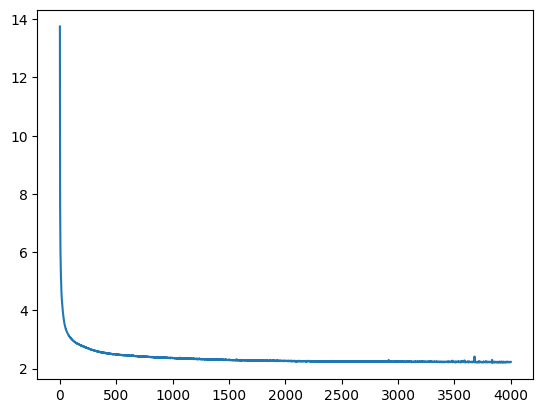

In [11]:
x = df_logs[["epoch", "loss_total"]]["epoch"]
y = df_logs[["epoch", "loss_total"]]["loss_total"]


import matplotlib.pyplot as plt

plt.plot(x, y)
plt.show()